In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split

# Define transforms for data augmentation
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Loading CIFAR-10 dataset
cifar_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Split the dataset into train, pre-train, and test as given in the problem statement
train_size = int(0.05 * len(cifar_dataset))
pretrain_size = int(0.45 * len(cifar_dataset))
test_size = len(cifar_dataset) - train_size - pretrain_size

train_dataset, pretrain_dataset, test_dataset = random_split(cifar_dataset, [train_size, pretrain_size, test_size])

# Defining the data loaders
pretrain_loader = DataLoader(pretrain_dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:08<00:00, 20522559.67it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data


**Training EfficientNet model in PyTorch on train dataset and testing the performance on the test dataset.**

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import os

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# To delete cached model weights
cache_path = os.path.join(torch.hub._get_torch_home(), 'checkpoints')
cached_model_path = os.path.join(cache_path, 'efficientnet_b0-3dd342df.pth')

if os.path.exists(cached_model_path):
    os.remove(cached_model_path)

# Defining the EfficientNet model
model = models.efficientnet_b0(pretrained=True)
model = model.to(device)

# Accessing the final fully connected layer
num_ftrs = model.classifier[1].in_features  

# Replace the final layer with a new one for 10 classes
model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),  
    nn.Linear(num_ftrs, 10)
)

model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
# Fine-tuning loop
for epoch in range(5):  
    model.train()
    total_loss = 0.0
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Moving data to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_losses.append(total_loss)

# Testing the model on the test dataset
model.eval()
correct = 0
total = 0
final_accuracy = []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Moving data to GPU
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy_1 = correct /total
        final_accuracy.append(accuracy_1)
        
accuracy = correct /total
print(f'Test Accuracy: {accuracy * 100:.2f}%')


Files already downloaded and verified
Test Accuracy: 68.27%


**Performance comes out to be around 65% while runnning it multiple times**

**Now defining a SiameseJigsawModel to first pre-train the model on “pre-train data”**

In [22]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Check if GPU is available, else run on CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Split the dataset into train, pre-train, and test
train_size = int(0.05 * len(cifar_dataset))
pretrain_size = int(0.45 * len(cifar_dataset))
test_size = len(cifar_dataset) - train_size - pretrain_size

train_dataset, pretrain_dataset, test_dataset = random_split(cifar_dataset, [train_size, pretrain_size, test_size])

# Define data loaders
pretrain_loader = DataLoader(pretrain_dataset, batch_size=32, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the model for self-supervised pre-training
class SiameseJigsawModel(nn.Module):
    def __init__(self, num_permutations=64):
        super(SiameseJigsawModel, self).__init__()
        self.siamese_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )
        self.fc = nn.Linear(256 * 28 * 28, num_permutations)

    def forward(self, x):
        x = self.siamese_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# Creating the model and moving it to the specified device
siamese_model = SiameseJigsawModel(num_permutations=64).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(siamese_model.parameters(), lr=0.001)

# Self-supervised pre-training loop
for epoch in range(3):  
    siamese_model.train()
    for batch_idx,data in enumerate(pretrain_loader):
        inputs, _ = data  
        inputs = inputs.to(device)        # Moving input data to the same device as the model
        optimizer.zero_grad()
        outputs = siamese_model(inputs)
        loss = criterion(outputs, torch.arange(len(inputs)).to(outputs.device))
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print(f'Epoch [{epoch + 1}/{3}], Batch [{batch_idx}/{len(pretrain_loader)}], Loss: {loss.item():.4f}')



Epoch [1/3], Batch [0/704], Loss: 4.1576
Epoch [1/3], Batch [200/704], Loss: 3.4686
Epoch [1/3], Batch [400/704], Loss: 3.4754
Epoch [1/3], Batch [600/704], Loss: 3.4667
Epoch [2/3], Batch [0/704], Loss: 3.4891
Epoch [2/3], Batch [200/704], Loss: 3.4674
Epoch [2/3], Batch [400/704], Loss: 3.4716
Epoch [2/3], Batch [600/704], Loss: 3.4658
Epoch [3/3], Batch [0/704], Loss: 3.4731
Epoch [3/3], Batch [200/704], Loss: 3.4667
Epoch [3/3], Batch [400/704], Loss: 3.4653
Epoch [3/3], Batch [600/704], Loss: 3.4679


**Fine-tuning on train Data**

In [23]:
# After pre-training, remove the self-supervised head and add a new classification head for fine-tuning
siamese_model.fc = nn.Linear(256 * 28 * 28, 10)  # Modifying the CIFAR-10 classes

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(siamese_model.parameters(), lr=0.001)

fine_tune_losses = []
# Fine-tuning loop
for epoch in range(5):  
    siamese_model.train()
    total_loss = 0.0
    for batch_idx,data in enumerate(train_loader): 
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Moving input data to the same device as the model
        siamese_model = siamese_model.to(device)
        optimizer.zero_grad()
        outputs = siamese_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if batch_idx % 30 == 0:
            print(f'Epoch [{epoch + 1}/{5}], Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')
    fine_tune_losses.append(total_loss)

Epoch [1/5], Batch [0/79], Loss: 2.3030
Epoch [1/5], Batch [30/79], Loss: 2.2530
Epoch [1/5], Batch [60/79], Loss: 2.1593
Epoch [2/5], Batch [0/79], Loss: 1.8787
Epoch [2/5], Batch [30/79], Loss: 1.9904
Epoch [2/5], Batch [60/79], Loss: 2.1008
Epoch [3/5], Batch [0/79], Loss: 2.2767
Epoch [3/5], Batch [30/79], Loss: 1.7142
Epoch [3/5], Batch [60/79], Loss: 1.8107
Epoch [4/5], Batch [0/79], Loss: 2.1277
Epoch [4/5], Batch [30/79], Loss: 1.9002
Epoch [4/5], Batch [60/79], Loss: 2.0267
Epoch [5/5], Batch [0/79], Loss: 1.5936
Epoch [5/5], Batch [30/79], Loss: 1.9180
Epoch [5/5], Batch [60/79], Loss: 2.0469


**Testing the fine-tuned model on the test dataset**

In [24]:

siamese_model.eval()
correct = 0
total = 0
fine_tune_accuracy= []
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Moving input data to the same device as the model
        outputs = siamese_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        accuracy_2 = correct / total
        fine_tune_accuracy.append(accuracy_2)
accuracy = correct / total
print(f'Fine-tuned Model Test Accuracy: {accuracy * 100:.2f}%')


Fine-tuned Model Test Accuracy: 33.05%


**Visualizing Loss accompained with both methods and with every loop**

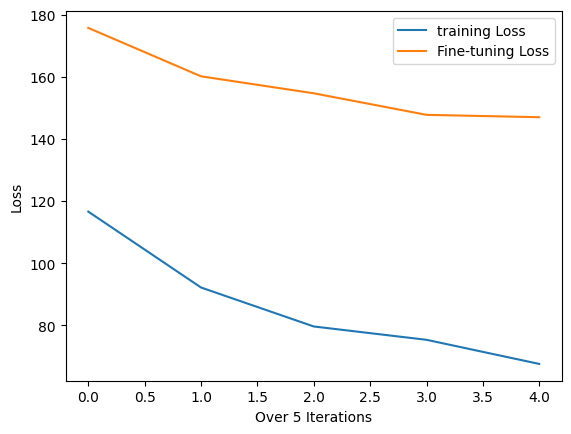

In [25]:
import matplotlib.pyplot as plt
plt.plot(train_losses, label='training Loss')
plt.plot(fine_tune_losses, label='Fine-tuning Loss')
plt.xlabel('Over 5 Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Visualizing Performance with each batch of 32 images**

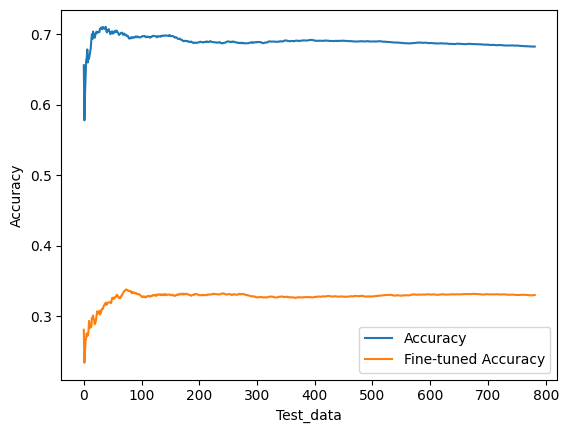

In [26]:
plt.plot(final_accuracy, label='Accuracy')
plt.plot(fine_tune_accuracy, label='Fine-tuned Accuracy')
plt.xlabel('Test_data')
plt.ylabel('Accuracy')
plt.legend()
plt.show()